In [1]:
# Install required libraries
!pip install yfinance ccxt pandas numpy transformers matplotlib scikit-learn tensorflow

# Import libraries
import yfinance as yf
import ccxt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.6/288.6 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.11
    Uninstalling aiohttp-3.11.11:
      Successfully uninstalled aiohttp-3.11.11


In [2]:
# Fetch stock data using Yahoo Finance
def fetch_stock_data(ticker, start_date='2020-01-01'):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date)
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    return df

# Fetch cryptocurrency data using CCXT
def fetch_crypto_data(symbol='BTC/USDT', exchange='kraken'):
    exchange_class = getattr(ccxt, exchange)
    exchange_instance = exchange_class()
    ohlcv = exchange_instance.fetch_ohlcv(symbol, timeframe='1d', limit=1000)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Fetch data for all assets
apple_data = fetch_stock_data('AAPL', '2020-01-01')
tesla_data = fetch_stock_data('TSLA', '2020-01-01')
btc_data = fetch_crypto_data('BTC/USD')
eth_data = fetch_crypto_data('ETH/USD')

# Display data
print("Apple Data:\n", apple_data.head())
print("\nBitcoin Data:\n", btc_data.head())


Apple Data:
                   timestamp       open       high        low      close  \
0 2020-01-02 00:00:00-05:00  71.799866  72.856606  71.545380  72.796013   
1 2020-01-03 00:00:00-05:00  72.020439  72.851769  71.862900  72.088303   
2 2020-01-06 00:00:00-05:00  71.206077  72.701500  70.954010  72.662720   
3 2020-01-07 00:00:00-05:00  72.672402  72.929314  72.100410  72.320969   
4 2020-01-08 00:00:00-05:00  72.022843  73.787300  72.022843  73.484337   

      volume  
0  135480400  
1  146322800  
2  118387200  
3  108872000  
4  132079200  

Bitcoin Data:
    timestamp     open     high      low    close       volume
0 2023-01-23  22717.1  23166.6  22520.1  22926.1  3015.649855
1 2023-01-24  22926.0  23158.7  22455.9  22633.8  3077.643596
2 2023-01-25  22636.0  23829.3  22320.0  23056.5  5020.204657
3 2023-01-26  23063.2  23293.3  22857.5  23010.6  3753.163921
4 2023-01-27  23010.6  23500.0  22492.8  23077.5  3420.533974


In [3]:
# Add moving averages and volatility as features
def add_technical_indicators(data):
    data['ma_10'] = data['close'].rolling(window=10).mean()
    data['ma_20'] = data['close'].rolling(window=20).mean()
    data['volatility'] = data['close'].rolling(window=10).std()
    data = data.dropna()  # Drop rows with NaN values from rolling calculations
    return data

# Add indicators for all datasets
apple_data = add_technical_indicators(apple_data)
tesla_data = add_technical_indicators(tesla_data)
btc_data = add_technical_indicators(btc_data)
eth_data = add_technical_indicators(eth_data)


In [4]:
# Preprocess data for LSTM
def preprocess_data(data, feature_cols=['close', 'ma_10', 'ma_20', 'volatility'], seq_length=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[feature_cols])  # Scale features

    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i])  # Sequence input
        y.append(scaled_data[i, 0])  # Predict close price

    return np.array(X), np.array(y), scaler

# Preprocess all datasets
seq_length = 60
X_apple, y_apple, apple_scaler = preprocess_data(apple_data)
X_tesla, y_tesla, tesla_scaler = preprocess_data(tesla_data)
X_btc, y_btc, btc_scaler = preprocess_data(btc_data)
X_eth, y_eth, eth_scaler = preprocess_data(eth_data)


In [5]:
# Build LSTM model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train LSTM model
def train_lstm(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
    return model, history

# Train LSTM models for all assets
def train_all_lstm_models():
    assets = {'Apple': (X_apple, y_apple), 'Tesla': (X_tesla, y_tesla),
              'Bitcoin': (X_btc, y_btc), 'Ethereum': (X_eth, y_eth)}
    models = {}

    for asset, (X, y) in assets.items():
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        print(f"\nTraining LSTM for {asset}...")
        model = build_lstm((seq_length, X.shape[2]))
        model, _ = train_lstm(model, X_train, y_train, X_test, y_test)
        models[asset] = (model, X_test, y_test)

    return models

lstm_models = train_all_lstm_models()



Training LSTM for Apple...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0331 - val_loss: 0.0154
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031 - val_loss: 0.0101
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0014

Training LSTM for Tesla...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0676 - val_loss: 0.0074
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0

In [8]:
# Load GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_gpt2 = AutoModelForCausalLM.from_pretrained(model_name)

# Set pad token to eos_token to handle padding properly
tokenizer.pad_token = tokenizer.eos_token

# Prepare sequences for GPT-2 with controlled input length
def prepare_gpt2_input(X, max_features=20):
    """
    Convert sequences to text format for GPT-2. Limit input length by restricting the number of features.
    """
    return [" ".join(map(str, seq.flatten()[:max_features])) for seq in X]

# Prepare GPT-2 inputs for all assets
assets_gpt2_inputs = {
    "Apple": prepare_gpt2_input(X_apple[:10]),
    "Tesla": prepare_gpt2_input(X_tesla[:10]),
    "Bitcoin": prepare_gpt2_input(X_btc[:10]),
    "Ethereum": prepare_gpt2_input(X_eth[:10])
}

# GPT-2 Prediction function
def gpt2_predict(sequence, model, tokenizer, max_new_tokens=10, max_input_length=1024):
    """
    Generate predictions using GPT-2 for a given input sequence.
    """
    # Tokenize the input sequence with truncation and padding
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, max_length=max_input_length, padding=True)

    # Generate predictions
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.pad_token_id  # Ensure proper handling of padding
    )

    # Decode the output and extract the predicted value
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    try:
        return float(prediction.split()[-1])  # Extract the last numeric value
    except ValueError:
        return None  # Return None if the prediction is not numeric

# Predict for all assets
gpt2_predictions = {asset: [gpt2_predict(seq, model_gpt2, tokenizer) for seq in inputs]
                    for asset, inputs in assets_gpt2_inputs.items()}

# Display predictions
for asset, predictions in gpt2_predictions.items():
    print(f"{asset} GPT-2 Predictions:", predictions)


Apple GPT-2 Predictions: [0.098477514757514, 0.098477575757575, 0.098477514757575, 0.098477514757575, 0.098477514757575, 0.1034751401494909, 0.098477514757514, 0.088477514751475, 0.08908847751475, 0.08908847751475]
Tesla GPT-2 Predictions: [0.03901098477514, 0.03909847751455, 0.03901098477575, 0.03901098477514, 0.03901098477514, 0.03909847751401, 0.03909847757575, 0.064751475757575, 0.06814010984775, 0.03909847757514]
Bitcoin GPT-2 Predictions: [0.03909847757569, 0.010984775757575, 0.010984775140155, 0.03909847751401, 0.038160175140149, 0.010109847751401, 0.010109847751401, 0.04901098477514, 0.007514010984775, 0.01098477575897]
Ethereum GPT-2 Predictions: [0.03909088477514, 0.03909847751401, 0.03909847751401, 0.099571584152028, 0.099571584152028, 0.03909847995555, 0.03909847995555, 0.0390101010101, 0.03909847995514, 0.0674954179615905]



Evaluating LSTM for Apple...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Apple LSTM Predictions - MSE: 0.0013595209814867123, RMSE: 0.0368716826506021


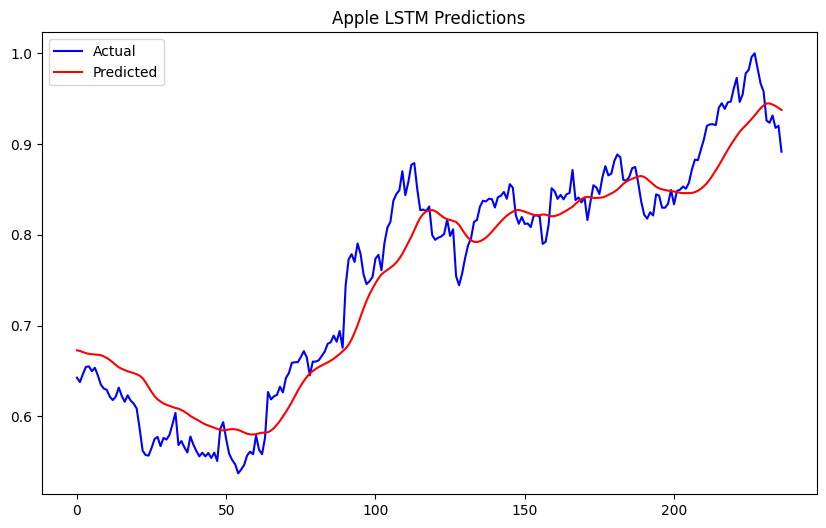


Evaluating GPT-2 for Apple...
Apple GPT-2 Predictions - MSE: 0.30145934998841606, RMSE: 0.5490531394941806


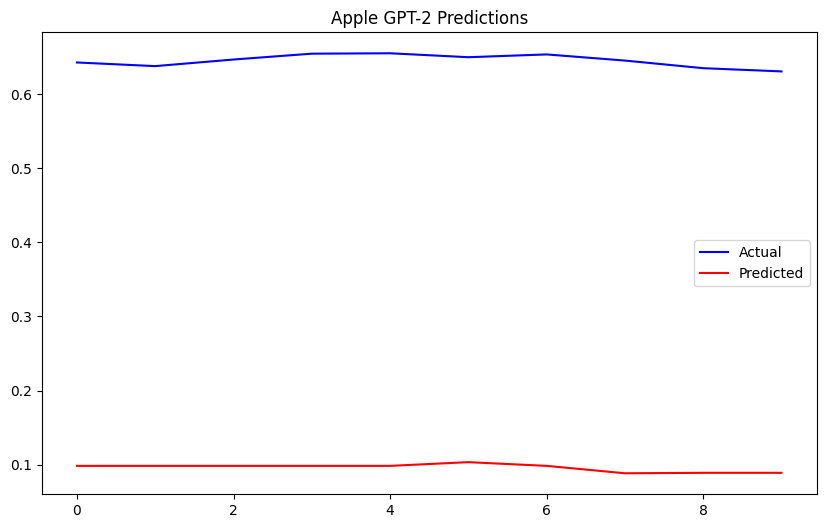


Evaluating LSTM for Tesla...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tesla LSTM Predictions - MSE: 0.0025606140840830622, RMSE: 0.050602510649997025


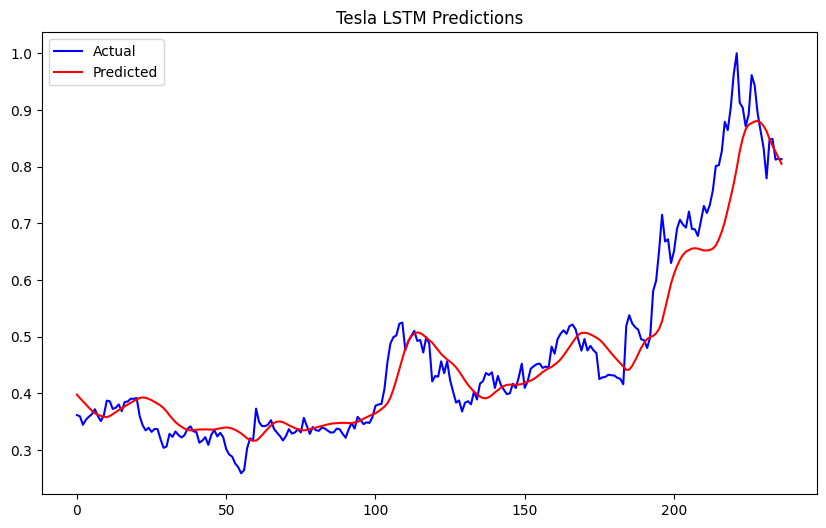


Evaluating GPT-2 for Tesla...
Tesla GPT-2 Predictions - MSE: 0.09874337581403328, RMSE: 0.3142345872338583


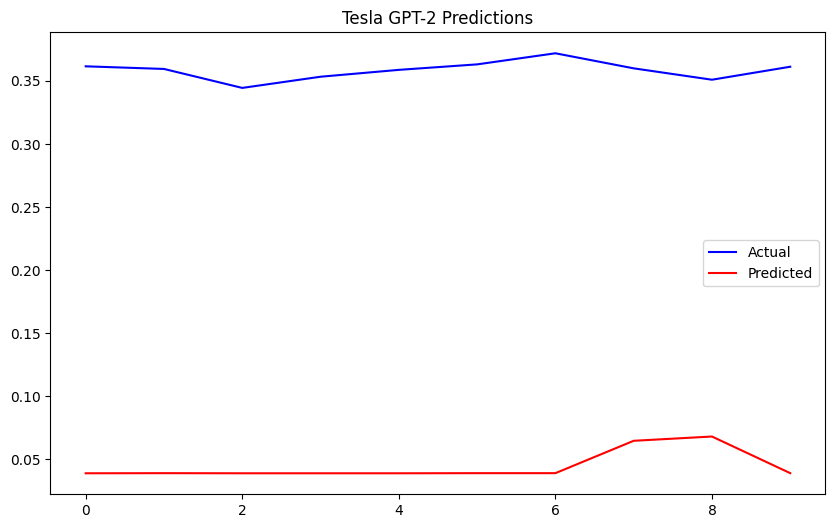


Evaluating LSTM for Bitcoin...


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Bitcoin LSTM Predictions - MSE: 0.00980266044385667, RMSE: 0.09900838572493074


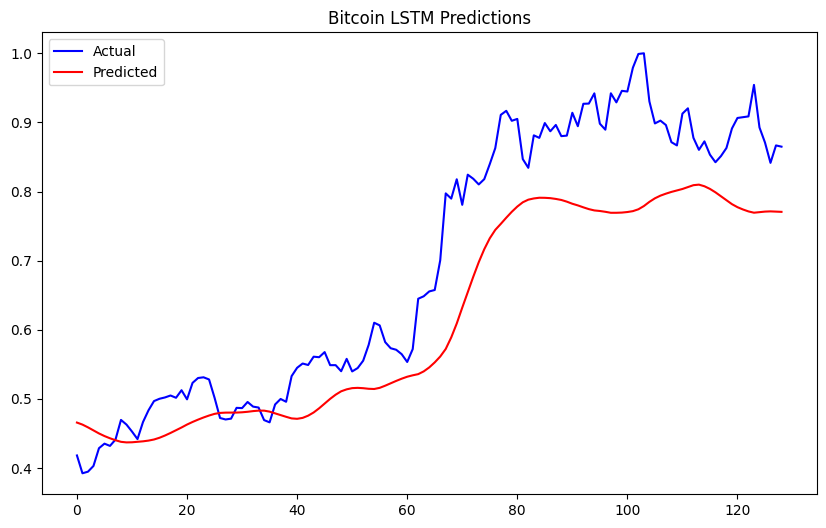


Evaluating GPT-2 for Bitcoin...
Bitcoin GPT-2 Predictions - MSE: 0.16519932523797076, RMSE: 0.40644719858546297


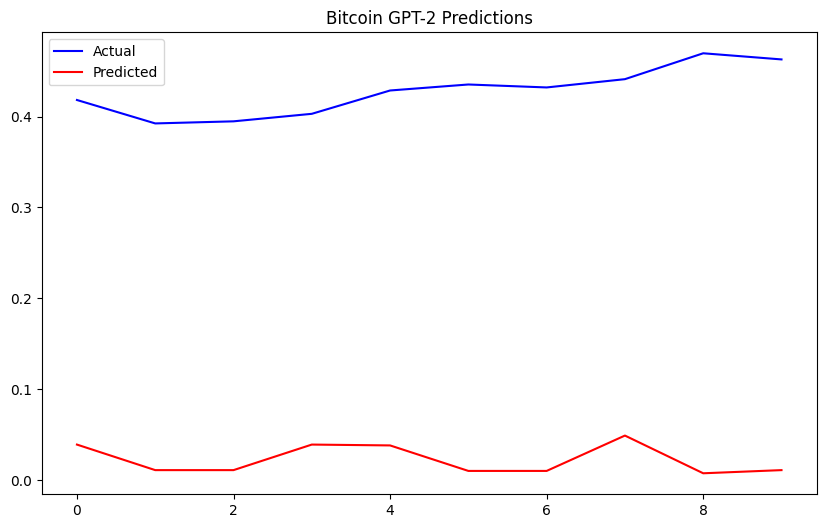


Evaluating LSTM for Ethereum...


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Ethereum LSTM Predictions - MSE: 0.009905561957084474, RMSE: 0.09952668967208984


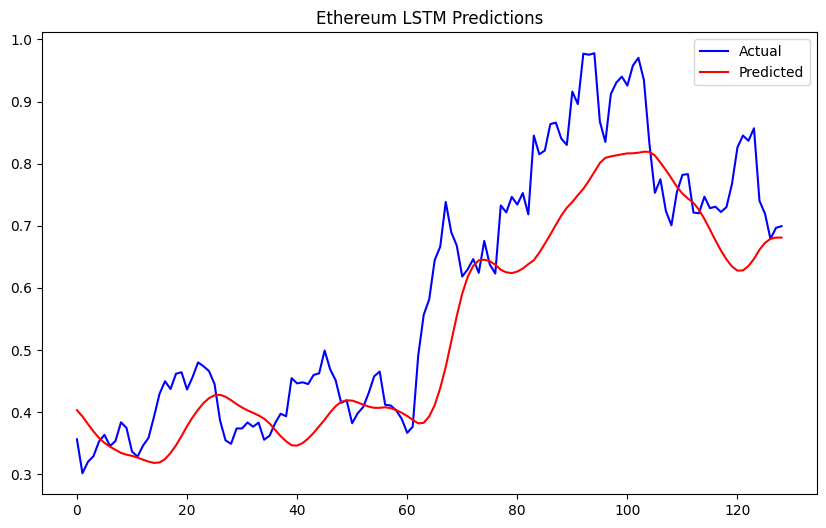


Evaluating GPT-2 for Ethereum...
Ethereum GPT-2 Predictions - MSE: 0.0875588981307763, RMSE: 0.2959035284189364


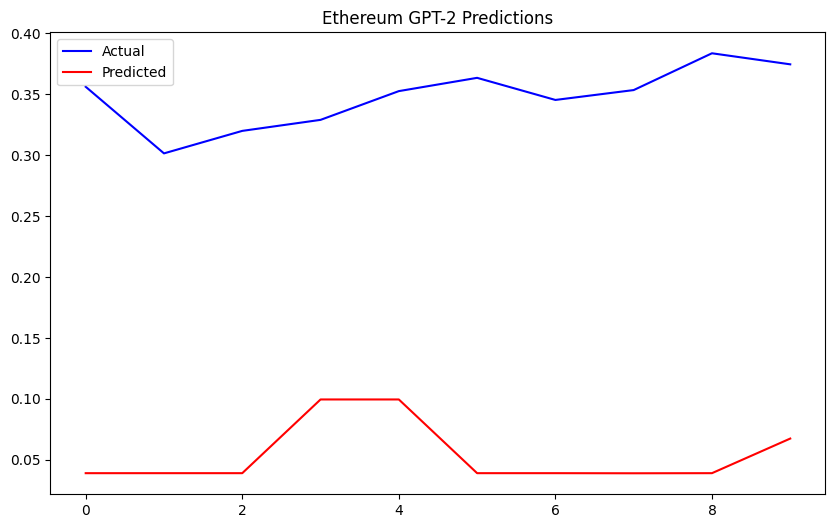

In [9]:
# Evaluate predictions
def evaluate_predictions(actual, predictions, title="Evaluation"):
    mse = mean_squared_error(actual[:len(predictions)], predictions)
    rmse = np.sqrt(mse)
    print(f"{title} - MSE: {mse}, RMSE: {rmse}")
    plt.figure(figsize=(10, 6))
    plt.plot(actual[:len(predictions)], label="Actual", color="blue")
    plt.plot(predictions, label="Predicted", color="red")
    plt.title(title)
    plt.legend()
    plt.show()

# Evaluate LSTM and GPT-2 for all assets
for asset, (model, X_test, y_test) in lstm_models.items():
    print(f"\nEvaluating LSTM for {asset}...")
    lstm_predictions = model.predict(X_test)
    evaluate_predictions(y_test, lstm_predictions, title=f"{asset} LSTM Predictions")

    print(f"\nEvaluating GPT-2 for {asset}...")
    evaluate_predictions(y_test[:len(gpt2_predictions[asset])], gpt2_predictions[asset], title=f"{asset} GPT-2 Predictions")
